In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigsh

### A

In [3]:
def gen_in_shape(N, padding, L, rectangle, circle):
    """
    Generates a 2D array filled with bools that tell if cell is in shape
    """
    
    # Construct 2D array with booleans of whether cell in shape
    in_shape = np.full((N+2*padding,N+2*padding), True)
    
    if not circle and not rectangle:
        # Put padding on False
        for j in range(N+2*padding):
            for i in range(N+2*padding):
                if j==0 or j==N+2*padding-1:
                    in_shape[j,i] = False
                if i==0 or i==N+2*padding-1:
                    in_shape[j,i] = False
        
    elif circle:
        center = int(N/2)+padding
        
        for j in range(0, N+2*padding):
            for i in range(0, N+2*padding):
                dist = np.sqrt((i-center)**2+(j-center)**2)
                if dist > int(N/2):
                    in_shape[j,i] = False
                
    elif rectangle:
        # Put padding on False
        in_shape = np.full((2*N+2*padding, N+2*padding), True)
        for j in range(2*N+2*padding):
            for i in range(N+2*padding):
                if j==0 or j==2*N+2*padding-1:
                    in_shape[j,i] = False
                if i==0 or i==N+2*padding-1:
                    in_shape[j,i] = False

    return in_shape

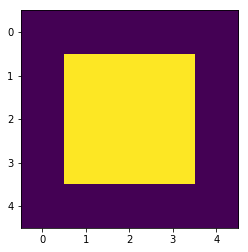

[[ 3.88888889 -1.          0.         -1.          0.          0.
   0.          0.          0.        ]
 [-1.          3.88888889 -1.          0.         -1.          0.
   0.          0.          0.        ]
 [ 0.         -1.          3.88888889  0.          0.         -1.
   0.          0.          0.        ]
 [-1.          0.          0.          3.88888889 -1.          0.
  -1.          0.          0.        ]
 [ 0.         -1.          0.         -1.          3.88888889 -1.
   0.         -1.          0.        ]
 [ 0.          0.         -1.          0.         -1.          3.88888889
   0.          0.          0.        ]
 [ 0.          0.          0.         -1.          0.          0.
   3.88888889 -1.          0.        ]
 [ 0.          0.          0.          0.         -1.          0.
  -1.          3.88888889 -1.        ]
 [ 0.          0.          0.          0.          0.         -1.
   0.         -1.          3.88888889]]


In [4]:
def gen_matrix(N, L=1, radius=0.5, K=-1, padding=1, rectangle=False, circle=False):
    """
    [3.1A] Generate matrix version
    """
    in_shape = gen_in_shape(N, padding, L, rectangle, circle)
    
    plt.imshow(in_shape)
    plt.show()
    
    dx = L/N
    
    # Set up M matrix and b vector
    M = np.zeros((N**2, N**2))
#     b = np.zeros(N**2)
    
    height_shape = N 
    if rectangle:
        M = np.zeros(((2*N**2, 2*N**2)))
        b = np.zeros(2*N**2)
        height_shape = 2*N
    
    cellcount = 0
    for j in range(height_shape):
        for i in range(N):
                    
            # Fill in value for cell itself
            if not in_shape[j+padding, i+padding]:
#                 M[cellcount, cellcount] = 0
                cellcount += 1
                continue
            
            M[cellcount, cellcount] = 4 + K*dx**2
                
            # Iterate over neighbors:
            if in_shape[j-1+padding, i+padding]:
                M[cellcount, cellcount-N] = -1
                    
            if in_shape[j+1+padding, i+padding]:
                if cellcount+N+padding < len(M[cellcount]):
                    M[cellcount, cellcount+N] = -1
                    
            if in_shape[j+padding, i+1+padding]:
                M[cellcount, cellcount+1] = -1  
                    
            if in_shape[j+padding, i-1+padding]:
                M[cellcount, cellcount-1] = -1
                
            cellcount += 1
    
    return M

N = 3
M = gen_matrix(N, L=1, circle=False)
print(M)

### B

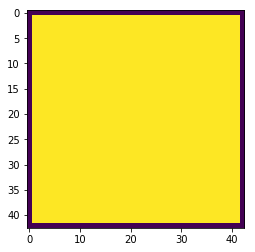

(array([8.04830346+0.00000000e+00j, 8.03155664+0.00000000e+00j,
       8.03155765+0.00000000e+00j, ..., 4.0594884 +7.51153155e-16j,
       4.0594884 -7.51153155e-16j, 4.0594884 +0.00000000e+00j]), array([[ 2.65938409e-04+0.00000000e+00j,  7.50126164e-04+0.00000000e+00j,
         2.93406738e-14+0.00000000e+00j, ...,
        -2.66502305e-16+1.98447283e-16j, -2.66502305e-16-1.98447283e-16j,
        -7.88462516e-16+0.00000000e+00j],
       [-5.30389565e-04+0.00000000e+00j, -1.48974968e-03+0.00000000e+00j,
        -6.28029817e-06+0.00000000e+00j, ...,
        -1.78584846e-03+2.71561845e-04j, -1.78584846e-03-2.71561845e-04j,
        -4.84842671e-04+0.00000000e+00j],
       [ 7.91874534e-04+0.00000000e+00j,  2.20856752e-03+0.00000000e+00j,
         2.49457791e-05+0.00000000e+00j, ...,
         9.41335025e-04+1.96580896e-02j,  9.41335025e-04-1.96580896e-02j,
        -2.45972657e-02+0.00000000e+00j],
       ...,
       [ 7.80878485e-04+0.00000000e+00j, -2.17569555e-03+0.00000000e+00j,
        -

In [40]:
N = 41
M_sq = gen_matrix(N, L=1)
# print(M_sq.shape)
# print(M_sq)
# eigenval_sq = eigsh(dia_matrix(M_sq))
eigenval_sq = linalg.eig(M_sq)
print(eigenval_sq)

# M_ci = gen_matrix(N, L=1, circle=True)
# eigenval_ci = linalg.eig(M_ci)

# M_rt = gen_matrix(N, L=1, rectangle=True)
# eigenval_rt = linalg.eig(M_rt)

[array([[ 0.00221876+0.j        ,  0.00065203+0.j        ,
         0.0055822 +0.j        , ..., -0.00692736-0.00504207j,
        -0.00692736+0.00504207j,  0.02458113+0.j        ]]), array([[ 0.00177931+0.j        ,  0.00031011+0.j        ,
         0.00468843+0.j        , ..., -0.00213886+0.01924207j,
        -0.00213886-0.01924207j,  0.00189934+0.j        ]]), array([[-0.00200464+0.j        , -0.00046267+0.j        ,
        -0.00516938+0.j        , ...,  0.00810241+0.00891153j,
         0.00810241-0.00891153j,  0.04219709+0.j        ]]), array([[-0.00154403+0.j        , -0.00019247+0.j        ,
        -0.00414477+0.j        , ...,  0.01171378+0.00994311j,
         0.01171378-0.00994311j,  0.02457406+0.j        ]])]


c:\users\juliu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.


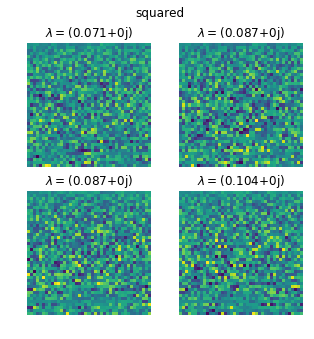

[array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.]])]


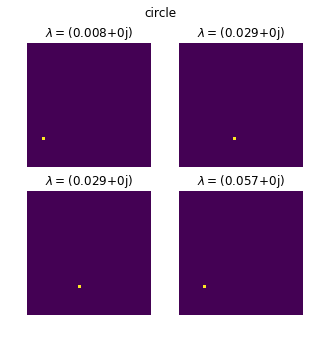

[array([[ 0.00126754+0.j, -0.00253326+0.j,  0.00379535+0.j, ...,
         0.00995309+0.j,  0.01114682+0.j, -0.03461399+0.j]]), array([[-0.00127827+0.j,  0.00255471+0.j, -0.00382748+0.j, ...,
        -0.01383324+0.j,  0.00961751+0.j,  0.03651344+0.j]]), array([[ 0.00128185+0.j, -0.00256187+0.j,  0.00383822+0.j, ...,
         0.01701005+0.j,  0.0087801 +0.j,  0.00328255+0.j]]), array([[-0.00127827+0.j,  0.00255471+0.j, -0.00382748+0.j, ...,
        -0.01407662+0.j,  0.0096594 +0.j, -0.03916603+0.j]])]


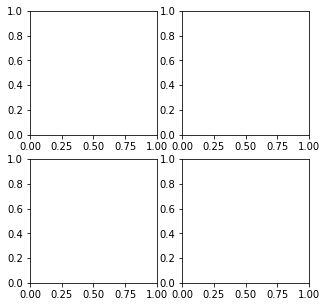

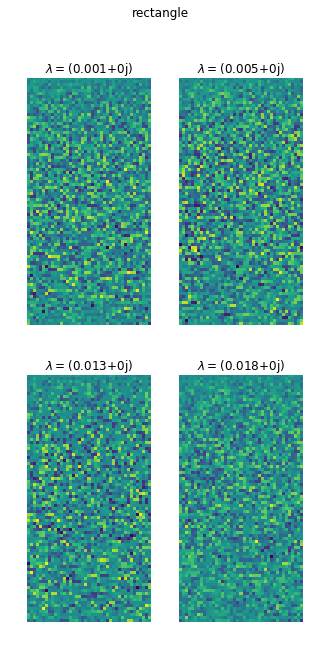

In [41]:
def comp_T(t, eigenval, A=1, B=1, c=1):
    return np.real(A*np.cos(c*eigenval*t) + B*np.sin(c*eigenval*t))


def plot_eigenvec_to_grid(eigen, N, name, rectangle=False):
    eigenval = eigen[0]
    eigenvec = eigen[1]
    
#     print(eigenval)
    
    # Get the smallest eigenvalues
    small_eigenvals = [sorted([e for e in eigenval if e>0])[i] for i in range(4)]
    
    small_eigenvecs = [eigenvec[np.where(eigenval==i)] for i in small_eigenvals]
    
    print(small_eigenvecs)
    
    fig, axes = plt.subplots(2,2,figsize=(5,5))
    if rectangle:
        fig, axes = plt.subplots(2,2,figsize=(5,10))  
    
    fig.suptitle(name)
    
    for i,plot in enumerate([(0,0), (0,1), (1,0), (1,1)]):
        
        y = []
        if not rectangle:
            y = np.real(np.reshape(small_eigenvecs[i], (N,N)))
        else:
            y = np.real(np.reshape(small_eigenvecs[i], (2*N,N)))
            
        T = np.array([[comp_T(t, small_eigenvals[i]) for j in range(y.shape[1])] 
                       for t in range(y.shape[0])])
        
#         axes[plot[0], plot[1]].imshow(y*T)
        axes[plot[0], plot[1]].imshow(y)
        axes[plot[0], plot[1]].axis('off')
        axes[plot[0], plot[1]].set_title('$\lambda= $'+str(round(small_eigenvals[i],3)))
    
    plt.show()

plot_eigenvec_to_grid(eigenval_sq, N, 'squared')

plot_eigenvec_to_grid(eigenval_ci, N, 'circle')

plot_eigenvec_to_grid(eigenval_rt, N, 'rectangle', rectangle=True)